__Анализ полученных результатов по переобучению модели ResNet50 с предобученными параметрами на ImageNet1k, для решения задачи классификации дорожных знаков (43 класса)__

In [127]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import models
from torchvision.transforms import v2 
import torch.nn as nn
from PIL import Image
import os

In [30]:
tl_model = torch.load(
    "..\\models\\save_tl_models\\my_resnet50_34.pth",
    map_location="cpu", weights_only=False
)
ft_model = torch.load(
    "..\\models\\save_ft_models\\my_resnet50_27.pth",
    map_location="cpu", weights_only=False
)

__Анализ графиков:__
--

__Этап 1: Transfer Learning (замороженный backbone)__

__График функции потерь на тренеровке и валидации:__

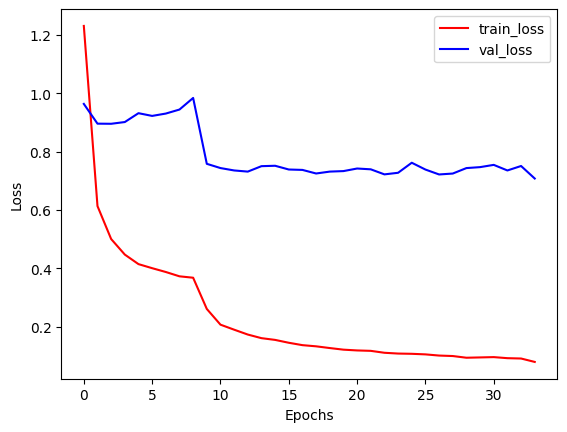

In [31]:
plt.plot(tl_model["history_of_education"]["loss"]["train"], c="r", label="train_loss")
plt.plot(tl_model["history_of_education"]["loss"]["val"], c="b", label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.close()

__График оценки точности модели на тренеровке и валидации:__

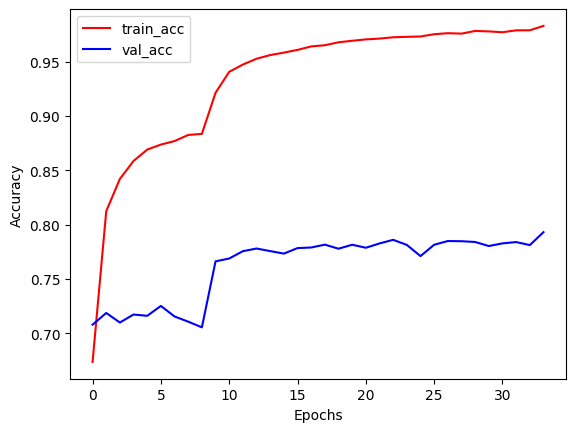

In [32]:
plt.plot(tl_model["history_of_education"]["accuracy"]["train"], c="r", label="train_acc")
plt.plot(tl_model["history_of_education"]["accuracy"]["val"], c="b", label="val_acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
plt.close()

__Выводы к 1 этапу:__
- train_acc быстро растёт с 67.4% до 92.1% за 10 эпох, val_acc улучшается с 70.8% до 76.6%. После 10-й эпохи обучение замедляется: val_acc колеблется в районе 77–78%, достигая максимума 79.3% на 34-й эпохе, можно сделать вывод, что нужно было уменьшать ожидание досрочной остановки обучения с 10->5, так как наиболее оптимальный результат достигается с 3-10 эпоху.

- Основная проблема при обучении классификатора возникает из-за переобучеия модели, которое связнно с недостаточной гибкостью замороженного backbone, который ограничивает возможно адаптации к новым данным.
Также и сам ImageNet1k, на котором были предобучены параметры в основном расчитан на классификацию природных объектов, а не дорожных знаков (имеется один общий класс "дорожный знак")

__Этап 2: Fine-Tuning (разморожены классификатор и layer4, остальная часть backbone)__

__График функции потерь на тренеровке и валидации:__

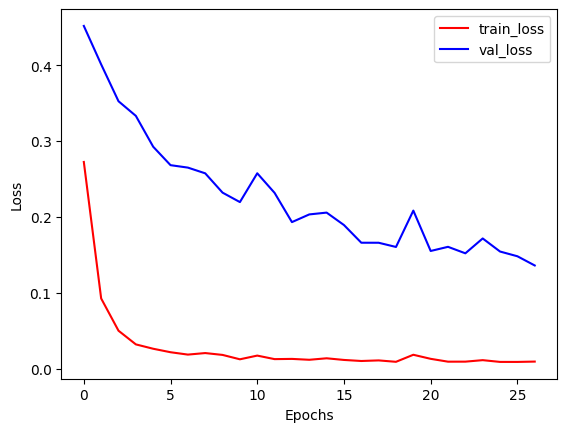

In [33]:
plt.plot(ft_model["history_of_education"]["loss"]["train"], c="r", label="train_loss")
plt.plot(ft_model["history_of_education"]["loss"]["val"], c="b", label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.close()

__График оценки точности модели на тренеровке и валидации:__

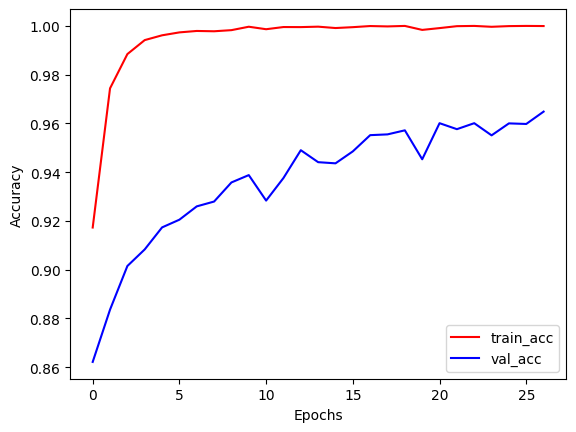

In [34]:
plt.plot(ft_model["history_of_education"]["accuracy"]["train"], c="r", label="train_acc")
plt.plot(ft_model["history_of_education"]["accuracy"]["val"], c="b", label="val_acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
plt.close()

__Выводы ко 2 этапу:__
- Резкий рост качества, val_acc сразу подскакивает до 86.2% (против 76.6% на 1 этапе), к 27-й эпохе достигает 96.5%.
train_acc быстро стремится к 100%, но val_loss снижается плавно, что указывает на более устойчивое обучение.

- Разморозка Layer4 позволила адаптировать высокоуровневые признаки под задачу, что резко повысило обобщающую способность, val_acc = 96.5% (на 27-й эпохе) против 79.3% на первом этапе.

- Для получения более высоких результатов можно попробывать разморозить layer3 и дообучить его.

__Ключивые гиперпараметры использующиеся при обучении:__
--

|Параметр|Этап 1|Этап 2|Комментарий|
|:-----------:|:-----------:|:-----------:|:-----------:|
|Batch Size|128|128|Большие размеры для лучшей работы batchnorm|
|Learning Rate (FC)|1e-3|1e-3|Не меняем шаг для более быстрой сходимости|
|Learning Rate (layer4)|-|3e-5|Уменьшенный шаг для тонкой настройки|
|Dropout|0.4, 0.2|0.5, 0.3|Dropout для уменьшение переобучения|
|Weight Decay (FC)|1e-3|1e-3|Регуляризация для уменьшения переобучения|
|Weight Decay (layer4)|-|1e-4|Регуляризация для уменьшения переобучения|

В классификаторе используется функция активации GELU вместо RELU, так как она более плавная чем RELU, не резко зануляют значения меньше 0, а делает это более плавно, что помогает избегать "мёртвых нейронов"

__Наглядная работа модели:__
--

In [39]:
resnet50 = models.resnet50()
fc = nn.Sequential(
    nn.Linear(in_features=2048,out_features=512, bias=False),
    nn.BatchNorm1d(512),
    nn.GELU(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=512,out_features=128, bias=False),
    nn.BatchNorm1d(128),
    nn.GELU(),
    nn.Dropout(p=0.3),
    nn.Linear(in_features=128, out_features=43)
)
resnet50.fc = fc

resnet50.load_state_dict(ft_model["model_state_dict"])

<All keys matched successfully>

In [38]:
transforms = v2.Compose([
    v2.Resize(size=(256,256)),
    v2.CenterCrop(size=(224,224)),
    v2.ToImage(),
    v2.ToDtype(dtype=torch.float32, scale=True),
    v2.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [134]:
labels = pd.read_csv("..\\data\\labels.csv").sort_values("ClassId")["Name"].to_list()
path = "..\\data\\jupyter_test"
file_list = os.listdir(path)

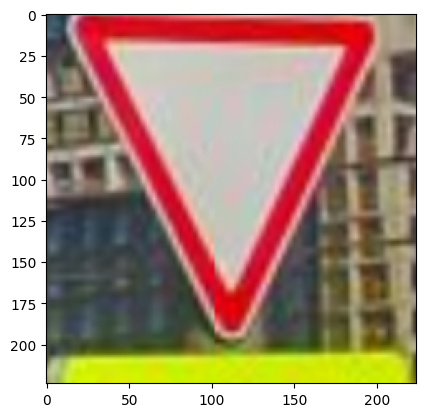

1) class_name: Give way => prob: 0.9926378726959229; cls_idx: 13
2) class_name: Entry is prohibited => prob: 0.0004636467492673546; cls_idx: 17
3) class_name: Speed limit (50km/h) => prob: 0.00041795099969021976; cls_idx: 2


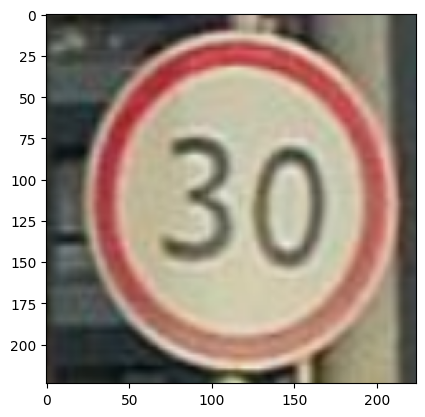

1) class_name: Speed limit (30km/h) => prob: 0.9249513149261475; cls_idx: 1
2) class_name: Speed limit (50km/h) => prob: 0.018964868038892746; cls_idx: 2
3) class_name: Speed limit (80km/h) => prob: 0.0046818493865430355; cls_idx: 5


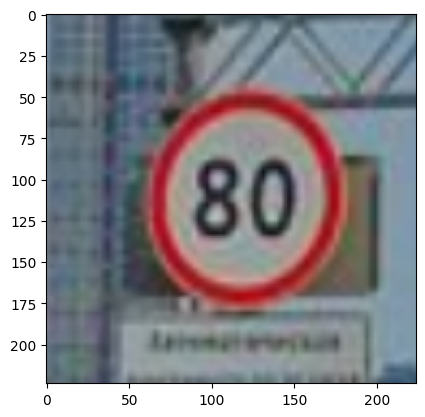

1) class_name: Speed limit (80km/h) => prob: 0.9195124506950378; cls_idx: 5
2) class_name: Speed limit (30km/h) => prob: 0.005051675718277693; cls_idx: 1
3) class_name: Intersection with a bike path or an off-road bike path => prob: 0.00467767845839262; cls_idx: 29


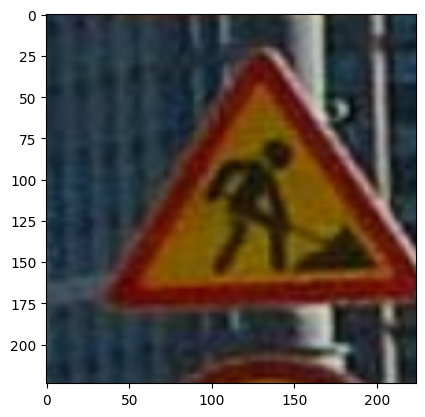

1) class_name: Road works => prob: 0.6256949305534363; cls_idx: 25
2) class_name: Main road => prob: 0.07346750050783157; cls_idx: 12
3) class_name: Children => prob: 0.05491765961050987; cls_idx: 28


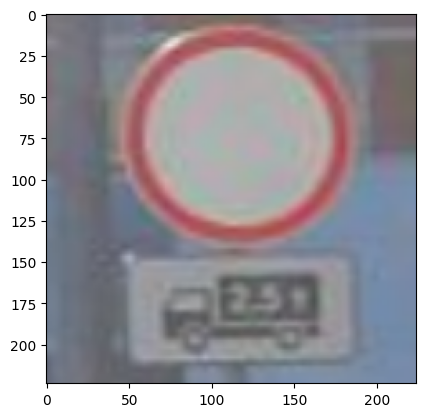

1) class_name: Traffic is prohibited => prob: 0.6134434342384338; cls_idx: 15
2) class_name: Speed limit (80km/h) => prob: 0.02542472817003727; cls_idx: 5
3) class_name: Movement to the right => prob: 0.022095423191785812; cls_idx: 33


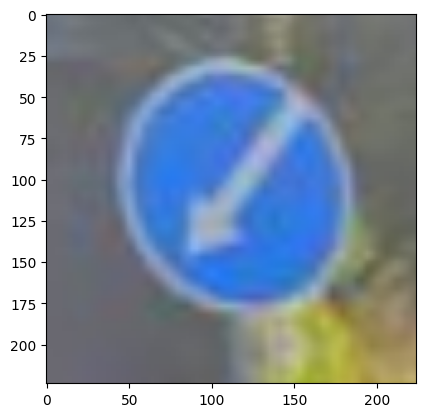

1) class_name: Detour obstacles on the left => prob: 0.19890527427196503; cls_idx: 39
2) class_name: Detour obstacles on the right => prob: 0.059914764016866684; cls_idx: 38
3) class_name: Go straight or turn left => prob: 0.052624475210905075; cls_idx: 37


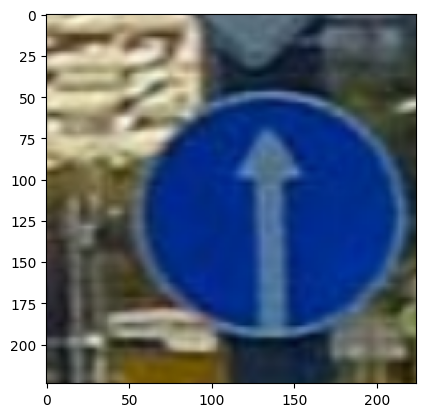

1) class_name: Moving straight => prob: 0.9829785227775574; cls_idx: 35
2) class_name: Other hazards => prob: 0.0010055691236630082; cls_idx: 18
3) class_name: Traffic is prohibited => prob: 0.0009866436012089252; cls_idx: 15


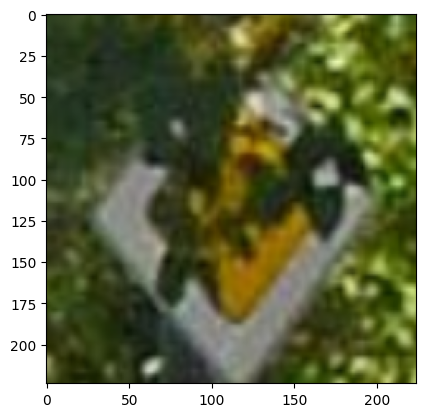

1) class_name: Main road => prob: 0.9958925247192383; cls_idx: 12
2) class_name: Circular motion => prob: 0.0002681513724382967; cls_idx: 40
3) class_name: Give way => prob: 0.0002493729116395116; cls_idx: 13


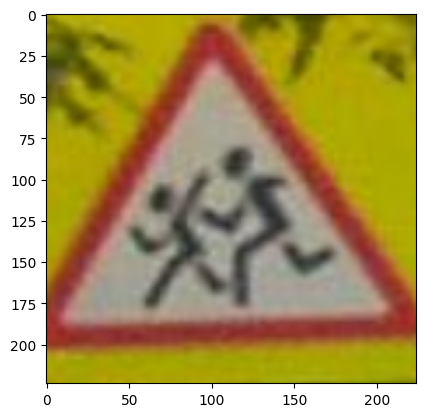

1) class_name: Children => prob: 0.8646717667579651; cls_idx: 28
2) class_name: Main road => prob: 0.08131027221679688; cls_idx: 12
3) class_name: Intersection with a bike path or an off-road bike path => prob: 0.01294065173715353; cls_idx: 29


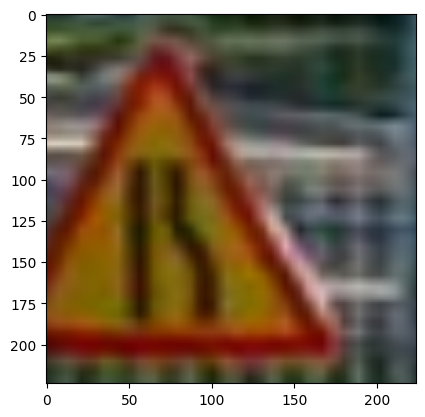

1) class_name: Narrowing of the road => prob: 0.30701228976249695; cls_idx: 24
2) class_name: Other hazards => prob: 0.2281564623117447; cls_idx: 18
3) class_name: Children => prob: 0.0515281967818737; cls_idx: 28


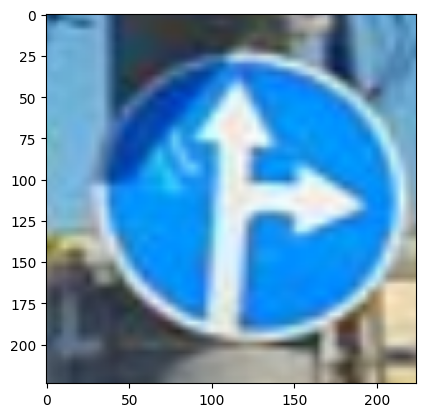

1) class_name: Going straight or going right => prob: 0.7883248925209045; cls_idx: 36
2) class_name: Moving straight => prob: 0.12240780889987946; cls_idx: 35
3) class_name: Turn left => prob: 0.005256368778645992; cls_idx: 34


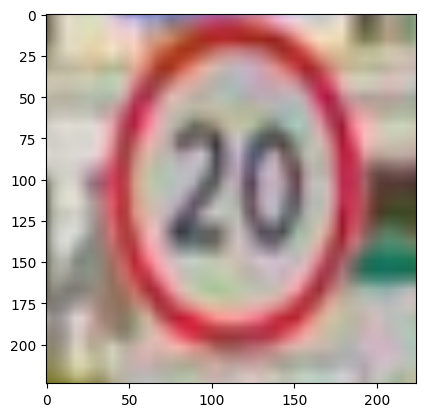

1) class_name: Speed limit (20km/h) => prob: 0.39105430245399475; cls_idx: 0
2) class_name: Speed limit (70km/h) => prob: 0.2895490229129791; cls_idx: 4
3) class_name: Speed limit (30km/h) => prob: 0.14691941440105438; cls_idx: 1


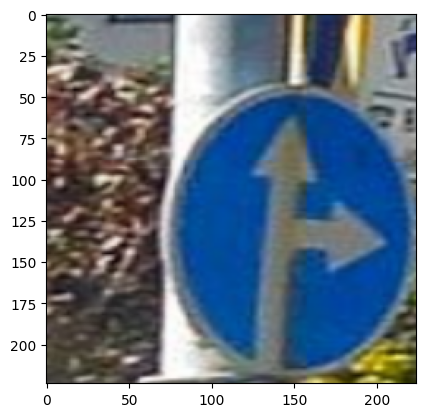

1) class_name: Moving straight => prob: 0.34526917338371277; cls_idx: 35
2) class_name: Going straight or going right => prob: 0.34201595187187195; cls_idx: 36
3) class_name: Road works => prob: 0.03342881426215172; cls_idx: 25


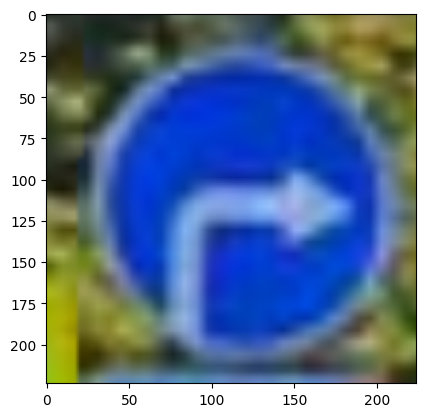

1) class_name: Movement to the right => prob: 0.9863965511322021; cls_idx: 33
2) class_name: Turn left => prob: 0.001250860164873302; cls_idx: 34
3) class_name: Detour obstacles on the left => prob: 0.0011755871819332242; cls_idx: 39


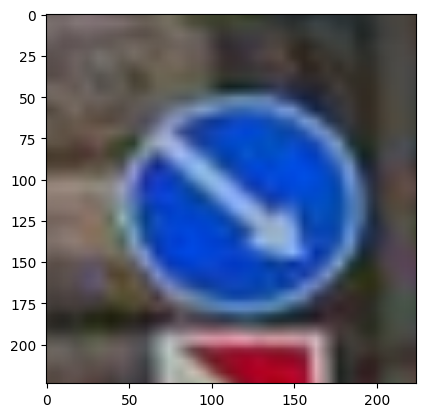

1) class_name: Detour obstacles on the right => prob: 0.8084405064582825; cls_idx: 38
2) class_name: Speed limit (50km/h) => prob: 0.02916913479566574; cls_idx: 2
3) class_name: Road works => prob: 0.015068442560732365; cls_idx: 25


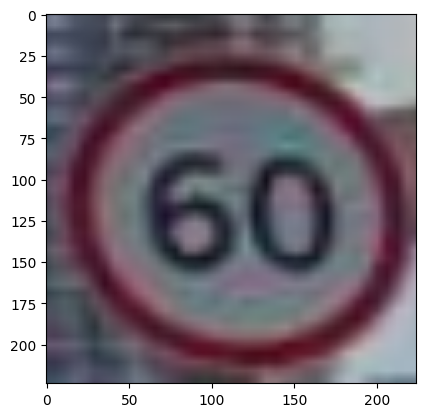

1) class_name: Speed limit (60km/h) => prob: 0.5606250166893005; cls_idx: 3
2) class_name: Speed limit (80km/h) => prob: 0.21827907860279083; cls_idx: 5
3) class_name: Speed limit (50km/h) => prob: 0.0264759324491024; cls_idx: 2


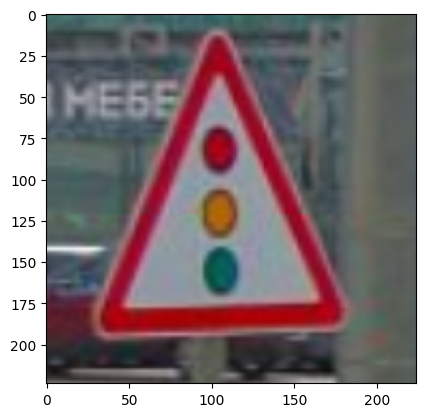

1) class_name: Traffic light regulation => prob: 0.983773946762085; cls_idx: 26
2) class_name: Give way => prob: 0.001540611730888486; cls_idx: 13
3) class_name: Other hazards => prob: 0.0011951586930081248; cls_idx: 18


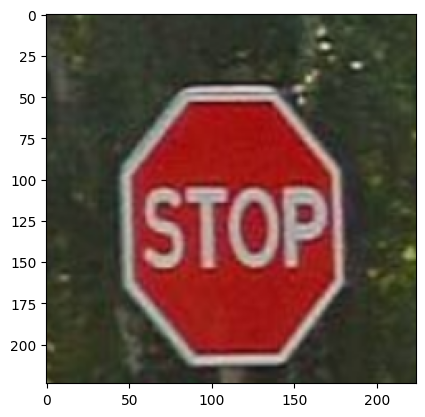

1) class_name: It is forbidden to move without stopping => prob: 0.996057391166687; cls_idx: 14
2) class_name: Dangerous turn (left) => prob: 0.0003408688062336296; cls_idx: 19
3) class_name: Circular motion => prob: 0.0003279904485680163; cls_idx: 40


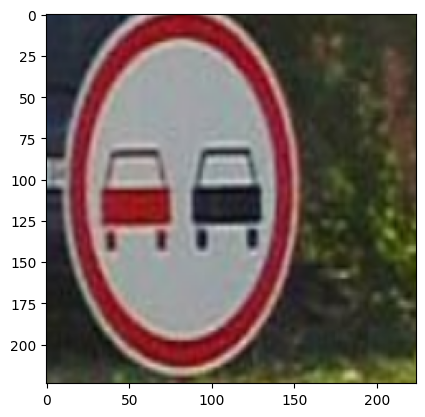

1) class_name: Overtaking is prohibited => prob: 0.9594334959983826; cls_idx: 9
2) class_name: Speed limit (50km/h) => prob: 0.014190681278705597; cls_idx: 2
3) class_name: Overtaking by truck is prohibited => prob: 0.001439871615730226; cls_idx: 10


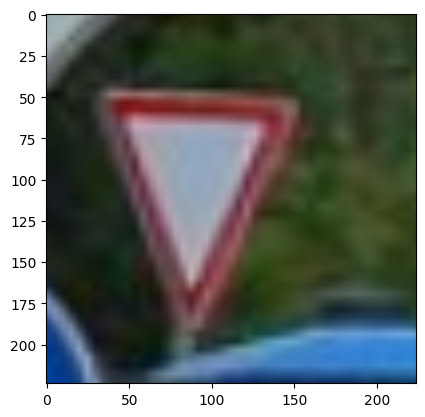

1) class_name: Give way => prob: 0.9924387335777283; cls_idx: 13
2) class_name: Speed limit (50km/h) => prob: 0.0005920910043641925; cls_idx: 2
3) class_name: Speed limit (60km/h) => prob: 0.0005102292052470148; cls_idx: 3


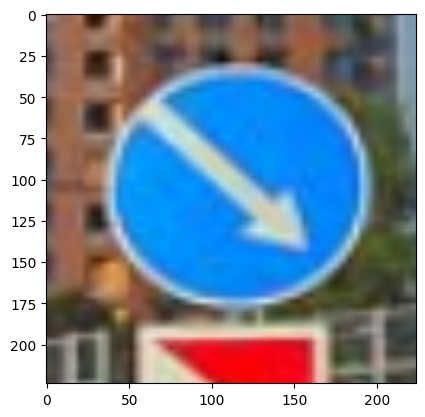

1) class_name: Detour obstacles on the right => prob: 0.7936750054359436; cls_idx: 38
2) class_name: Speed limit (50km/h) => prob: 0.027073722332715988; cls_idx: 2
3) class_name: Turn left => prob: 0.018603425472974777; cls_idx: 34


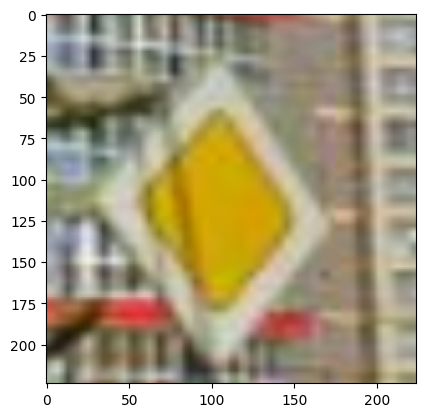

1) class_name: Main road => prob: 0.9956140518188477; cls_idx: 12
2) class_name: Wild animals => prob: 0.0002789681020658463; cls_idx: 31
3) class_name: Entry is prohibited => prob: 0.00025901212939061224; cls_idx: 17


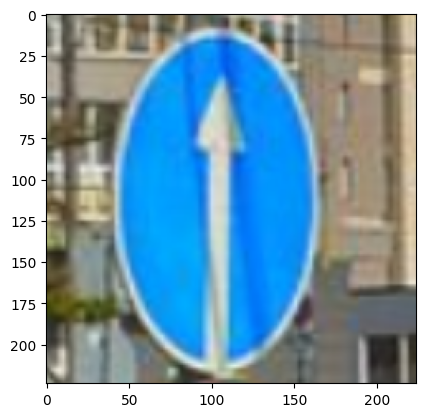

1) class_name: Moving straight => prob: 0.965440034866333; cls_idx: 35
2) class_name: Other hazards => prob: 0.0036236364394426346; cls_idx: 18
3) class_name: Going straight or going right => prob: 0.0018724120454862714; cls_idx: 36


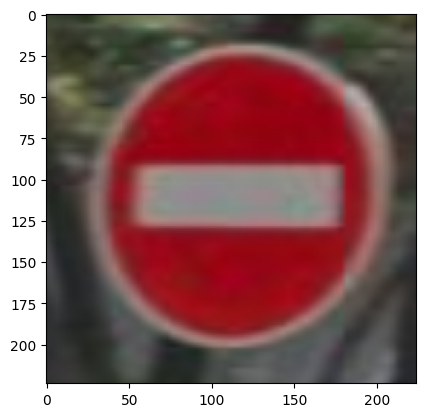

1) class_name: Entry is prohibited => prob: 0.9914708733558655; cls_idx: 17
2) class_name: Give way => prob: 0.0010195672512054443; cls_idx: 13
3) class_name: It is forbidden to move without stopping => prob: 0.000532770121935755; cls_idx: 14


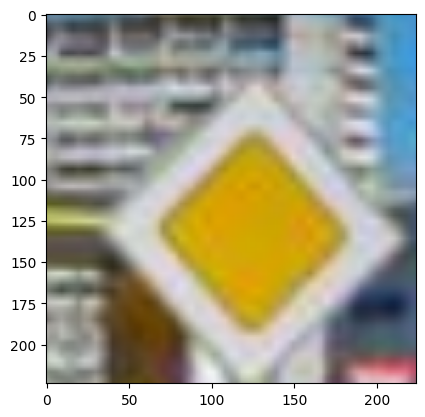

1) class_name: Main road => prob: 0.9992228746414185; cls_idx: 12
2) class_name: Slippery slope => prob: 5.437157960841432e-05; cls_idx: 23
3) class_name: Wild animals => prob: 4.925544635625556e-05; cls_idx: 31


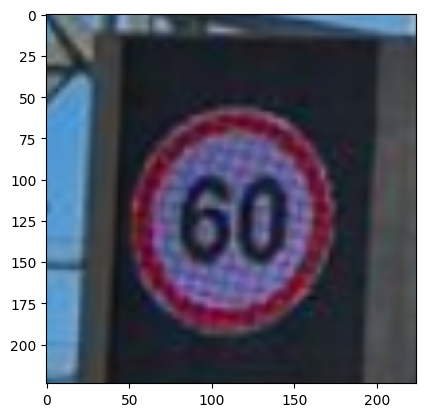

1) class_name: Speed limit (80km/h) => prob: 0.41876184940338135; cls_idx: 5
2) class_name: Speed limit (60km/h) => prob: 0.09963331371545792; cls_idx: 3
3) class_name: Give way => prob: 0.04574129730463028; cls_idx: 13


In [135]:
for file_name in file_list:
    img = Image.open(os.path.join(path, file_name)).convert("RGB")
    img = transforms(img)

    img_t = img.permute(1,2,0) * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    plt.imshow(img_t)
    plt.show() 

    resnet50.eval()
    pred = resnet50(img.unsqueeze(dim=0)).squeeze()
    sort, idx = pred.softmax(dim=0).sort(descending=True)
    for i, (sort, idx) in enumerate(zip(sort,idx)):
        print(f"{i+1}) class_name: {labels[idx]} => prob: {sort}; cls_idx: {idx}")
        if i == 2:
            break